<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 1  </H3>
<hr style="height:2px;border:none"/> 

Integrantes:
- Diego Jara (201304530-8)
- Miguel Ibáñez (2990010-8)


Secciones:

[1.](#primero) Aprendizaje con regresión lineal  
[2.](#segundo) Análisis de audios como datos brutos  
[3.](#tercero) Análisis de emociones en tweets

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<a id="primero"></a>
## 1. Aprendizaje con regresión lineal.

**a)** Datos

In [3]:
df = pd.read_csv("world-university-rankings/timesData.csv")

In [7]:
print(df.shape)
df.describe()

(2603, 14)


,teaching,research,citations,student_staff_ratio,year
count,2603.000000,2603.000000,2603.000000,2544.000000,2603.000000
mean,37.801498,35.910257,60.921629,18.445283,2014.075682
std,17.604218,21.254805,23.073219,11.458698,1.685733
min,9.900000,2.900000,1.200000,0.600000,2011.000000
25%,24.700000,19.600000,45.500000,11.975000,2013.000000
50%,33.900000,30.500000,62.500000,16.100000,2014.000000
75%,46.400000,47.250000,79.050000,21.500000,2016.000000
max,99.700000,99.400000,100.000000,162.600000,2016.000000


**b)** Pre-procesamiento

Se eliminan las filas a las que les falte un valor (ya sea 'nan' o el string "-"), exceptuando aquellas a las que les falta sólo en la columna "total_score"

In [4]:
df.dropna(axis=0,inplace=True,how='any') #borra nan
df.loc[df["total_score"]=='-',["total_score"]] = "unknown"
df = df[~(df == '-').any(axis=1)] #elimina filas con valores nulos

Se pasa la columna "country" (variable categórica) a una serie de variables booleanas para cada una de las categorías (países). Luego, se agregan las columnas "male" y "female" con las proporsiones de cada uno y la columna "female_male_ratio" se convierte a decimal. Finalmente, se limpia de formato las columnas "num_students" e "international_students".

In [5]:
def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
    return x

In [6]:
nuevo_df  = pd.get_dummies(df, columns=["country"]) #column to categorical

nuevo_df['female'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[0].apply(convertToInt)
nuevo_df['male'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[1].apply(convertToInt)
nuevo_df['female_male_ratio'] =  np.where(nuevo_df['male'] == 0, 0, nuevo_df['female']/nuevo_df['male']) #si no hay (rellena 0) 
nuevo_df['num_students'] = nuevo_df['num_students'].apply(lambda x: int(str(x).replace(',','')))
nuevo_df['international_students'] = nuevo_df['international_students'].apply(lambda x: int(str(x).replace('%','')))

Se separan en, dos conjuntos, aquellas filas que tienen "tota_score" definido de aquellas que no. 

In [7]:
df_test = nuevo_df[nuevo_df["total_score"]=='unknown']  #para predecir al final
nuevo_df =  nuevo_df[nuevo_df["total_score"]!='unknown'] #elimina unknown rank..
print(nuevo_df.shape)
nuevo_df.head()

(954, 82)


,world_rank,university_name,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,...,country_Taiwan,country_Thailand,country_Turkey,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States of America,female,male
1,2,California Institute of Technology,97.7,54.6,98.0,99.9,83.7,96.0,2243,6.9,...,0,0,0,0,0,0,0,1,33,67
2,3,Massachusetts Institute of Technology,97.8,82.3,91.4,99.9,87.5,95.6,11074,9.0,...,0,0,0,0,0,0,0,1,37,63
3,4,Stanford University,98.3,29.5,98.1,99.2,64.3,94.3,15596,7.8,...,0,0,0,0,0,0,0,1,42,58
5,6,University of Cambridge,90.5,77.7,94.1,94.0,57.0,91.2,18812,11.8,...,0,0,0,0,0,0,1,0,46,54
6,6,University of Oxford,88.2,77.2,93.9,95.1,73.5,91.2,19919,11.6,...,0,0,0,0,0,0,1,0,46,54


**c)** Creación de los conjuntos de entrenamiento, validación y test

In [9]:
Y = nuevo_df['total_score'].values
X = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).values
Y = Y.astype('float32')
X = X.astype('float32')

# Target
X_tgt = df_test.drop(["total_score","world_rank","university_name"],axis=1).values
X_tgt = X_tgt.astype('float32')



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


# TODO validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

**d)** Normalización

In [10]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

**e)** Regresión Lineal

C:\Users\mibanez\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


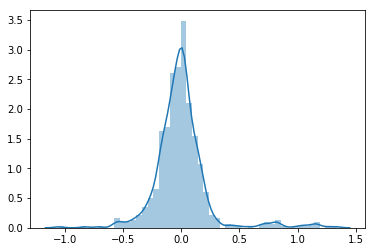

In [11]:
# from sklearn.linear_model import LinearRegression as LR
linreg = LR(fit_intercept=True, n_jobs=1)
linreg.fit(X_train_scaled,y_train)

# import seaborn as sns

# Plot diferencia
res = y_train-linreg.predict(X_train_scaled)
sns.distplot(res)

**f)** Z-score y F-score

**g)** Información mútua de los predictores con respecto al output.

In [36]:
from sklearn.feature_selection import mutual_info_regression

predictores = nuevo_df.columns.drop(["total_score","world_rank","university_name"]).tolist()

minfo_predictor = mutual_info_regression(X,Y)
minfo_predictor

# TODO desplegar info
# INFO Asume ambas listas en el mismo orden 
pd.DataFrame(minfo_predictor, predictores)

,0
teaching,0.883767
international,0.072969
research,0.901339
citations,0.314343
income,0.143268
num_students,0.276260
student_staff_ratio,0.287310
international_students,0.341810
female_male_ratio,0.299112
year,0.234710


**h)** Forward Step-wise Selection (FSS)

In [ ]:
def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = [p]
    current_score = 0.0
    best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        # TODO seleccion candidato
        for candidate in remaining:
            model = LR(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        # TODO print ?
#         print "selected = {:s} ...".format(names_x[best_candidate])
#         print "totalvars=%d, mse = %f"%(len(indexes),best_new_score)
    return selected
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
fss(X_train_scaled,y_train,names_regressors)

plot error de entrenamiento y error de pruebas en función del número de predictores.

In [37]:
# TODO

**i)** Ridge Regression

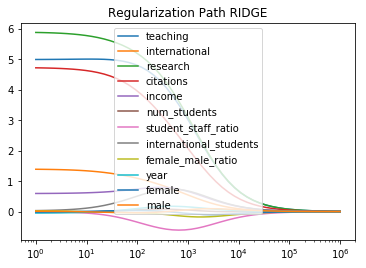

Text(0.5,1,'Regularization Path RIDGE of country coefs')

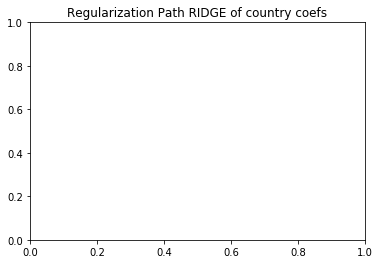

In [41]:
from sklearn.linear_model import Ridge

names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
plt.show()

# TODO Plot para "country"
if "country" in label:
    plt.plot(alphas_, y_arr, label=label)
plt.title('Regularization Path RIDGE of country coefs')

**j)** Lasso

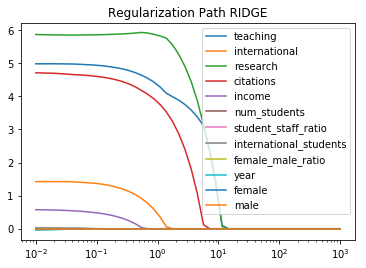

In [42]:
from sklearn.linear_model import Lasso


alphas_ = np.logspace(-2,3,base=10)
coefs = []
model = Lasso(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
plt.show()

# TODO Plot para "country"

# country_alphas_ = np.logspace(-5,0,base=10)

**k)** Plot: error de entrenamiento y error de pruebas en función del parámetro de regularización para modelo (a_escoger)

In [ ]:
alphas_ = #choose it
coefs = []
model = #choose it
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test = model.predict(X_test_scaled)
    mse_train.append(np.mean(np.power(yhat_train - y_train, 2)))
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error ridge/lasso')
ax.plot(alphas_,mse_test,label='test error ridge/lasso')
plt.legend(loc=1)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

**l)** k-fold

**m)** Ranking *target data*

<a id="segundo"></a>
## 2. Análisis de audios como datos brutos

<a id="tercero"></a>
## 3. Análisis de emociones en tweets